FORMERLY KNOWN AS COPY OF BERTO (RIP)

In [1]:
import torch
import numpy as np
import pandas as pd
import random
import os
import time
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from sklearn.metrics import matthews_corrcoef
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [45]:
# CHOOSE MODEL
vanilla = 'bert-base-uncased' # this is basic bert and has no saved weights, to train

davidson = "bert_baselines/davidson" # to load
# parler_base_davidson = "bert_baselines/parler_base_davidson" # to load
# davidson_binary = "bert_baselines/davidson_binary"

# parler_100k = "bert_parler_100k/parler_100k"
parler_100k_davidson = "bert_parler_100k/parler_100k_davidson"
# parler_100k_davidson_reddit = "bert_parler_100k/parler_100k_davidson_reddit"
# parler_100k_davidson_gab = "bert_parler_100k/parler_100k_davidson_gab"

parler_1m_davidson = "bert_parler_1m/parler_1m_davidson"
# parler_1m_reddit = "bert_parler_1m/parler_1m_reddit"
# parler_1m_gab = "bert_parler_1m/parler_1m_gab"

parler_6m_davidson = "bert_parler_6m/parler_6m_davidson"
# parler_6m_reddit = "bert_parler_6m/parler_6m_reddit"
# parler_6m_gab = "bert_parler_6m/parler_6m_gab"
# parler_6m_gab_8epoch = "bert_parler_6m/parler_6m_gab_8epoch"
parler_final_davidson = "bert_parler_final/parler_final_davidson"

fourchan_davidson = 'bert_4chan_nov3/4chan_davidson'
# fourchan_reddit = 'bert_4chan_nov3/4chan_reddit'
# fourchan_gab = 'bert_4chan_nov3/4chan_gab'

# ASSIGN MODEL HERE
model_name = davidson

# TRUE IF YOU ARE TESTING MODEL, FALSE IF YOU ARE TRAINING MODEL
# if model = vanilla
# train_model = True

# if model != vanilla
train_model = False


# UNCOMMENT BELOW BASED ON WHO IS RUNNING

# for joli (julia/oliver), assuming this works for both
prefix = "/content/drive/MyDrive/CS224N_Project"

# for jackson
# prefix = "/content/drive/MyDrive/Classes/Coterm/Winter Quarter/CS224N/CS224N_Project"

os.chdir(prefix)
output_dir = f'{prefix}/model_weights/{model_name}'
# if using vanilla model
# output_dir = f'{prefix}/model_weights/bert_train'

In [37]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [4]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
!pip install transformers

In [6]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertModel
from transformers import get_linear_schedule_with_warmup

In [7]:
# Load the dataset into a pandas dataframe.
df = pd.read_csv("data/davidson_labeled_data.csv", header=None)#, names=)
df = df.drop([0], axis=0)
df = df.drop([0], axis=1)

# for class: 0 - hate speech, 1 - offensive language, 2 - neither
df.columns = ["count","hate_speech","offensive_language","neither","class","tweet"]
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.head()

Number of training sentences: 24,783



,count,hate_speech,offensive_language,neither,class,tweet
1,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
2,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
3,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
4,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
5,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# train_end = int(df.shape[0]*0.8)
# val_end = train_end + int(df.shape[0]*0.1)
# test_end = val_end + int(df.shape[0]*0.1)

# df = df.sample(frac=1).reset_index(drop=True)
# df[:train_end].to_csv("data/split_data_oliver/Davidson_train.csv")
# df[train_end:val_end].to_csv("data/split_data_oliver/Davidson_val.csv")
# df[val_end:].to_csv("data/split_data_oliver/Davidson_test.csv")


In [9]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
1,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
2,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
3,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
4,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
5,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [10]:
# Workers were asked to label each tweet as one of three categories:
# hate speech, offensive but not hate speech, or neither offensive nor hate speech.
# for class: 0 - hate speech, 1 - offensive language but not hate speech, 2 - neither offensive or hate speech
print(f"class 0 (hate speech) makes up: {round(len(df[df['class'] == '0'])*100 / len(df), 2)} % of the dataset")
print(f"class 1 (offensive language) makes up: {round(len(df[df['class'] == '1'])*100 / len(df), 2)} % of the dataset")
print(f"class 2 (neither) makes up: {round(len(df[df['class'] == '2'])*100 / len(df), 2)} % of the dataset")

class 0 (hate speech) makes up: 5.77 % of the dataset
class 1 (offensive language) makes up: 77.43 % of the dataset
class 2 (neither) makes up: 16.8 % of the dataset


In [11]:
sentences = df["tweet"].values
labels = df["class"].values

In [12]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [13]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
Tokenized:  ['!', '!', '!', 'rt', '@', 'maya', '##sol', '##ove', '##ly', ':', 'as', 'a', 'woman', 'you', 'shouldn', "'", 't', 'complain', 'about', 'cleaning', 'up', 'your', 'house', '.', '&', 'amp', ';', 'as', 'a', 'man', 'you', 'should', 'always', 'take', 'the', 'trash', 'out', '.', '.', '.']
Token IDs:  [999, 999, 999, 19387, 1030, 9815, 19454, 21818, 2135, 1024, 2004, 1037, 2450, 2017, 5807, 1005, 1056, 17612, 2055, 9344, 2039, 2115, 2160, 1012, 1004, 23713, 1025, 2004, 1037, 2158, 2017, 2323, 2467, 2202, 1996, 11669, 2041, 1012, 1012, 1012]


In [14]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  481


In [15]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = np.array(labels, dtype=np.int64)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...


In [16]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-10-10 train-validation-test split.
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = int((len(dataset) - train_size)/2)
test_size = int(len(dataset) - train_size - val_size)

#additional check
assert(len(dataset) == train_size+val_size+test_size)

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

19,826 training samples
2,478 validation samples
2,479 test samples


In [19]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

prediction_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = RandomSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [46]:
# Load a trained model and vocabulary that you have fine-tuned
load_model_name = ""
if model_name != "bert-base-uncased":
  load_model_name = "model_weights/" + model_name
  print(f"loading {load_model_name}")
else:
  load_model_name = model_name
  print(f"loading {load_model_name}")

model = BertForSequenceClassification.from_pretrained(
    load_model_name, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

# choose specific tokenizer (if there is one)
# tokenizer = tokenizer_class.from_pretrained(load_dir)

# Tell pytorch to run this model on the GPU.
model.cuda()
# Copy the model to the GPU.
model.to(device)

loading model_weights/bert_baselines/davidson


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [21]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [22]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [23]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [25]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

TRAIN MODEL

In [26]:
if train_model:
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
          if step % 2000 == 0 and not step == 0:
            # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
            # Create output directory if needed
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            print("Saving model to %s" % output_dir)

            # Save a trained model, configuration and tokenizer using `save_pretrained()`.
            # They can then be reloaded using `from_pretrained()`
            model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
            model_to_save.save_pretrained(output_dir)
            tokenizer.save_pretrained(output_dir)
            # Good practice: save your training arguments together with the trained model
            # torch.save(args, os.path.join(output_dir, 'training_args.bin'))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          
          # loss, logits = model(b_input_ids, 
          #                      token_type_ids=None, 
          #                      attention_mask=b_input_mask, 
          #                      labels=b_labels)
          output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
          loss = output.loss
          logits = output.logits
          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epoch took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
              loss = output.loss
              logits = output.logits
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [27]:
if train_model:
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(data=training_stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # A hack to force the column headers to wrap.
  #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

  # Display the table.
  print(df_stats)

In [28]:
if train_model:
  # Use plot styling from seaborn.
  sns.set(style='darkgrid')

  # Increase the plot size and font size.
  sns.set(font_scale=1.5)
  plt.rcParams["figure.figsize"] = (12,6)

  # Plot the learning curve.
  plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
  plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

  # Label the plot.
  plt.title("Training & Validation Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks([1, 2, 3, 4])

  plt.show()

TESTING

In [47]:
# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()
text = []
# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  for item in b_input_ids:
    text.append(tokenizer.convert_ids_to_tokens(item))
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  logits = outputs.logits #outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 24,783 test sentences...
    DONE.


In [48]:
matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


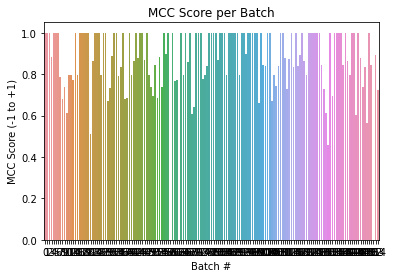

In [49]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
# ax.figure(figsize=(12,8))
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')
plt.show()
fig = ax.get_figure()
#fig.savefig(f"images/{model_name}_mcc_davidson.png")

In [50]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.881


In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Constants

# Print the confusion matrix
mtx = confusion_matrix(flat_true_labels, flat_predictions)

# Print the precision and recall, among other metrics
print(metrics.classification_report(flat_true_labels, flat_predictions, digits=3))

              precision    recall  f1-score   support

           0      0.784     0.599     0.679       152
           1      0.967     0.979     0.973      1906
           2      0.954     0.981     0.967       421

    accuracy                          0.956      2479
   macro avg      0.902     0.853     0.873      2479
weighted avg      0.953     0.956     0.954      2479



In [44]:
parler_final_predictions = flat_predictions

In [52]:
davidson_better = []
for i in range(len(text)):
  if flat_true_labels[i] ==  flat_predictions[i] and flat_true_labels[i] != parler_final_predictions[i]:
    davidson_better.append((text[i], flat_true_labels[i]))

In [53]:
len(davidson_better)

720

In [55]:
df_samples = pd.DataFrame(davidson_better)
df_samples.to_excel("Parler_final_Davidson_vs_baseline.xlsx")

Parler_final

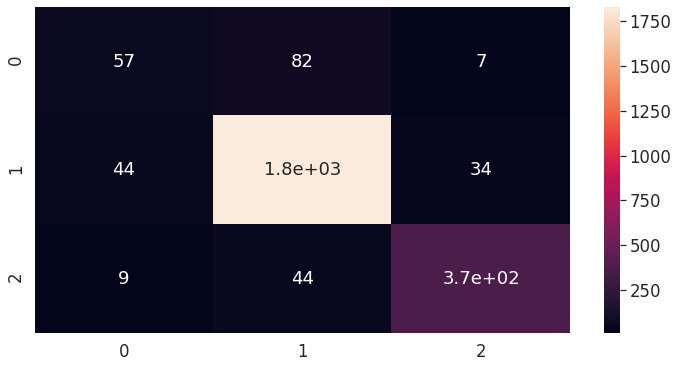

In [ ]:
import seaborn as sns
sns.heatmap(mtx, annot=True)

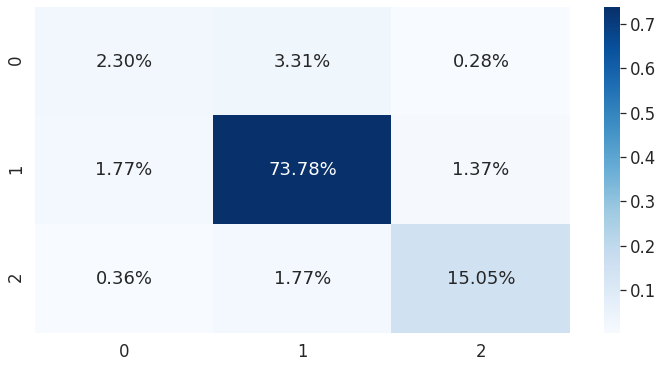

In [ ]:
sns.heatmap(mtx/np.sum(mtx), annot=True, fmt='.2%', cmap='Blues')

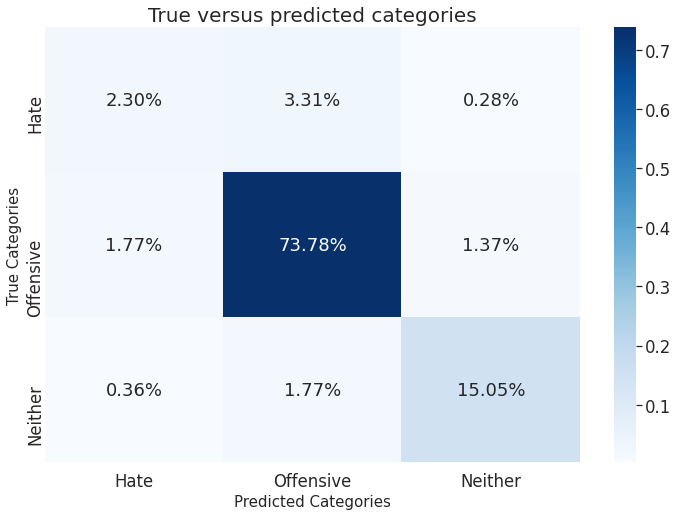

In [ ]:
plt.figure(figsize=(12,8))
ax = plt.axes()
sns.heatmap(mtx/np.sum(mtx), ax = ax, annot=True, fmt='.2%', cmap='Blues')
# ax.set_title('True versus predicted categories', )
plt.title('True versus predicted categories', fontsize = 20) # title with fontsize 20
plt.xlabel('Predicted Categories', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True Categories', fontsize = 15) # y-axis label with fontsize 15
plt.xticks(np.arange(start=0.5, step=1, stop=3.5), ["Hate", "Offensive", "Neither"], horizontalalignment='center')
plt.yticks(np.arange(start=0.5, step=1, stop=3.5), ["Hate", "Offensive", "Neither"], horizontalalignment='center')
# plt.show()
fig = ax.get_figure()
fig.savefig(f"images/{model_name}_mtx_davidson_v2.png")